In [1]:
import os
import csv
import copy
import numpy as np
import pandas as pd
from scipy import signal
from scipy.fftpack import fft,ifft
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'SimHei'
plt.rcParams['axes.unicode_minus'] = False 

%matplotlib notebook

## 必备的函数

In [2]:
'''滑动窗口中值滤波函数-->去基线漂移'''
def midFilter(Data,winLen):
    halfLen = winLen//2
    newData = np.insert(Data,0,[Data[0]]*halfLen)
    newData = np.append(newData,[Data[-1]]*halfLen)
    midFilterData = []
    for i in range(100,2100):
        temp = np.mean(newData[i-100:i+100])
        midFilterData.append(temp)
    midFilterData = np.array(midFilterData)
    return (Data-midFilterData)

'''Savitzky Golay滤波函数-->去波形毛刺'''
def Savitzky_Golay(data):
    return signal.savgol_filter(midFilter(data,200),53,3)

In [3]:
def standardization(data):
    mu = np.mean(data, axis=0)
    sigma = np.std(data, axis=0)
    return (data - mu) / sigma

In [4]:
def getTnum(Signal):
    XPower = abs(fft(Signal))
    XPower = XPower[0:100]
    loc = np.where(XPower==max(XPower))[0][0]
    zhuPin = loc/10
    T = 1/zhuPin
    fs = 200
    Tnum = int(round(T*fs))
    return Tnum

def getMaxMin(signal,x):
    maxLoc = int(np.where(signal == max(x))[0][0])
    minLoc = int(np.where(signal == min(x))[0][0])

    return max(x),min(x),maxLoc,minLoc

def getPeakAndTrough(Signal,alpha = 0.8):
    X = Signal
    
    MAX = []
    MIN = []
    MAXLOC = []
    MINLOC = []

    # alpha = 2/3
    
    Tnum = getTnum(X)
    halfT = int(Tnum/2)
    a = 0
    b = int((alpha)*Tnum)
    for i in range(int(np.ceil(len(X)/Tnum))):
        x = X[a:b]
        Max,Min,maxLoc,minLoc = getMaxMin(X,x)
        MAX.append(Max)
        MIN.append(Min)
        MAXLOC.append(maxLoc)
        MINLOC.append(minLoc)

        a = maxLoc+halfT
        b = a+int((alpha)*Tnum)

    return MAXLOC,MAX,MINLOC,MIN

## 3.2 整体波形异常

In [ ]:
'''
导入“演示用数据”文件夹的数据，第97_.csv文件
'''
badData = pd.read_csv(open('整体异常数据.csv',encoding= 'utf-8'),header=None).values
goodData = pd.read_csv(open('正常脉象数据.csv',encoding= 'utf-8'),header=None).values
'''
数据的采样率和采样时间
'''
fs = 200
t_ = 10
n = fs*t_
t = np.linspace(0,t_,n)

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(2,2,1)
badSignal = standardization(badData[1])
plt.plot(t[0:600],badSignal[0:600])
plt.xlabel('时间/秒')
plt.ylabel('幅度值')
# plt.legend()
plt.title('波形整体异常信号')

plt.subplot(2,2,2)
badFFT = abs(fft(badSignal))/len(badSignal)
f = fs/n*np.array(range(0,n))
f_ = f[0:50]
plt.plot(f_,badFFT[0:50],c='g')
maxLoc = np.where(badFFT==max(badFFT))[0][0]
print(f_[maxLoc])
plt.scatter(f_[maxLoc],badFFT[0:50][maxLoc],c='r',label='主频点')
plt.title('波形整体异常信号的幅频图(0-5Hz)')
plt.xlabel('频率')
plt.ylabel('幅度值')
plt.axvline(0.83,linestyle='--',c='r',label='正常范围')
plt.axvline(2.5,linestyle='--',c='r')
plt.legend()

plt.subplot(2,2,3)
goodSignal = Savitzky_Golay(goodData[1])
plt.plot(t[0:600],goodSignal[0:600])
plt.xlabel('时间/秒')
plt.ylabel('幅度值')
# plt.legend()
plt.title('正常脉象信号')

plt.subplot(2,2,4)
goodFFT = abs(fft(goodSignal))/len(goodSignal)
plt.plot(f_,goodFFT[0:50],c='g')
maxLoc = np.where(goodFFT==max(goodFFT))[0][0]
plt.scatter(f_[maxLoc],goodFFT[0:50][maxLoc],c='r',label='主频点')
plt.title('正常脉象信号的幅频图(0-5Hz)')
plt.xlabel('频率')
plt.ylabel('幅度值')
plt.axvline(0.83,linestyle='--',c='r',label='正常范围')
plt.axvline(2.5,linestyle='--',c='r')
plt.legend()

plt.tight_layout()
# plt.savefig(r'C:\Users\ASUS\Desktop\毕业论文PPT作图汇总\第三章\图3-9.png',dpi=600, bbox_inches='tight')
plt.show()

## 3.3方向异常

In [ ]:
signData = pd.read_csv(open('方向异常.csv',encoding= 'utf-8'),header=None).values
signSignal = Savitzky_Golay(signData[2])[0:1000]

'''
数据的采样率和采样时间
'''
fs = 200
t_ = 10
n = fs*t_
t = np.linspace(0,t_,n)


In [ ]:
tt = t[0:1000]
plt.figure()
plt.subplot(2,1,1)
plt.plot(tt,signSignal)

plt.subplot(2,1,2)
plt.plot(tt,-signSignal,c='r')

plt.show()

In [ ]:
tt = t[0:1000]
plt.figure()
plt.subplot(2,1,1)
plt.plot(tt,standardization(signSignal))
MAXLOC, MAX, MINLOC, MIN = getPeakAndTrough(standardization(signSignal), alpha=0.8)
plt.plot(tt[MINLOC[0]:MINLOC[1]],standardization(signSignal)[MINLOC[0]:MINLOC[1]])
plt.title('正方向信号')
plt.xlabel('时间/秒')
plt.ylabel('幅度值')

plt.subplot(2,1,2)
plt.plot(tt,standardization(-signSignal),c='r')
# MAXLOC, MAX, MINLOC, MIN = getPeakAndTrough(standardization(-signSignal), alpha=0.8)
# plt.plot(tt[MINLOC[0]:MINLOC[1]],standardization(-signSignal)[MINLOC[0]:MINLOC[1]])
plt.title('反方向信号')
plt.xlabel('时间/秒')
plt.ylabel('幅度值')

plt.tight_layout()
plt.show()

In [ ]:
tt = t[0:1000]
plt.figure(figsize=(10,4))
# plt.subplot(2,1,1)
plt.subplot2grid((2,4),(0,0),colspan = 3)
plt.plot(tt,standardization(signSignal))
MAXLOC, MAX, MINLOC, MIN = getPeakAndTrough(standardization(signSignal), alpha=0.8)
plt.plot(tt[MINLOC[0]:MINLOC[1]],standardization(signSignal)[MINLOC[0]:MINLOC[1]])
plt.title('正方向信号')
plt.xlabel('时间/秒')
plt.ylabel('幅度值')

# plt.subplot(2,1,2)
plt.subplot2grid((2,4),(1,0),colspan = 3)
plt.plot(tt,standardization(-signSignal),c='g')
# MAXLOC, MAX, MINLOC, MIN = getPeakAndTrough(standardization(-signSignal), alpha=0.8)
# plt.plot(tt[MINLOC[0]:MINLOC[1]],standardization(-signSignal)[MINLOC[0]:MINLOC[1]])
plt.title('反方向信号')
plt.xlabel('时间/秒')
plt.ylabel('幅度值')

plt.subplot2grid((2,4),(0,3),rowspan = 2)
x = standardization(signSignal)
plt.plot(tt[MINLOC[0]:MAXLOC[1]],x[MINLOC[0]:MAXLOC[1]],label='左上支')
plt.plot(tt[MAXLOC[1]:MINLOC[1]],x[MAXLOC[1]:MINLOC[1]],label='右下支')
plt.title('正方向信号一个周期')
plt.xlabel('时间/秒')
plt.ylabel('幅度值')
plt.legend()

plt.tight_layout()
plt.savefig(r'C:\Users\ASUS\Desktop\毕业论文PPT作图汇总\第三章\图3-10.png',dpi=600, bbox_inches='tight')
plt.show()

## 3.4 局部异常

In [5]:
partData = pd.read_csv(open('局部异常.csv',encoding= 'utf-8'),header=None).values
partSignal = partData[0]

'''
数据的采样率和采样时间
'''
fs = 200
t_ = 10
n = fs*t_
t = np.linspace(0,t_,n)

In [ ]:
plt.figure()
plt.plot(partSignal)
plt.show()

In [6]:
def chaZhi(threeX,threeY,length):
    '''
    二阶B样条插值
    '''
    from scipy.interpolate import interp1d
    
    xx = np.linspace(min(threeX),max(threeX), length)
    f = interp1d(threeX, threeY, kind = 'quadratic')
    return f(xx)

<IPython.core.display.Javascript object>


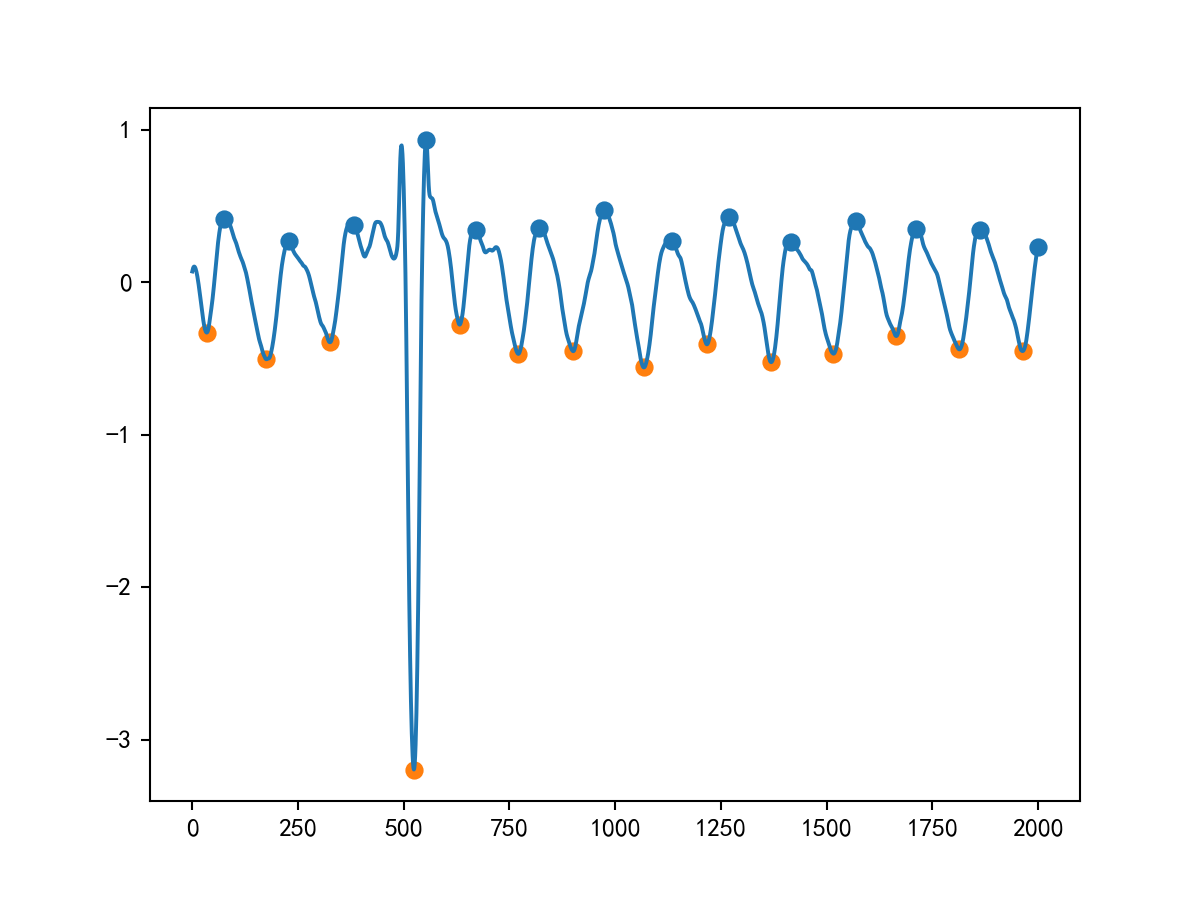

In [7]:
MAXLOC, MAX, MINLOC, MIN = getPeakAndTrough(partSignal, alpha=0.8)

plt.figure()
plt.plot(partSignal)
plt.scatter(MAXLOC,MAX)
plt.scatter(MINLOC,MIN)
plt.show()

In [ ]:
fengErr = MAX - np.median(MAX)
guErr = MIN - np.median(MIN)

In [8]:
m = np.median(MIN)
ratio = MIN/m
Loction = np.where(ratio>=2)[0]

for i in Loction:
    print(MINLOC[i],MIN[i])

524 -3.19534964150428


In [ ]:
Loction

In [ ]:
i

In [ ]:
x = [MAXLOC[i-1],MINLOC[i],MAXLOC[i+1]]
y = [MAX[i-1],MIN[i],MAX[i+1]]
xx = [MAXLOC[i-1]-MAXLOC[i-1],MINLOC[i]-MAXLOC[i-1],MAXLOC[i+1]-MAXLOC[i-1]]

<IPython.core.display.Javascript object>


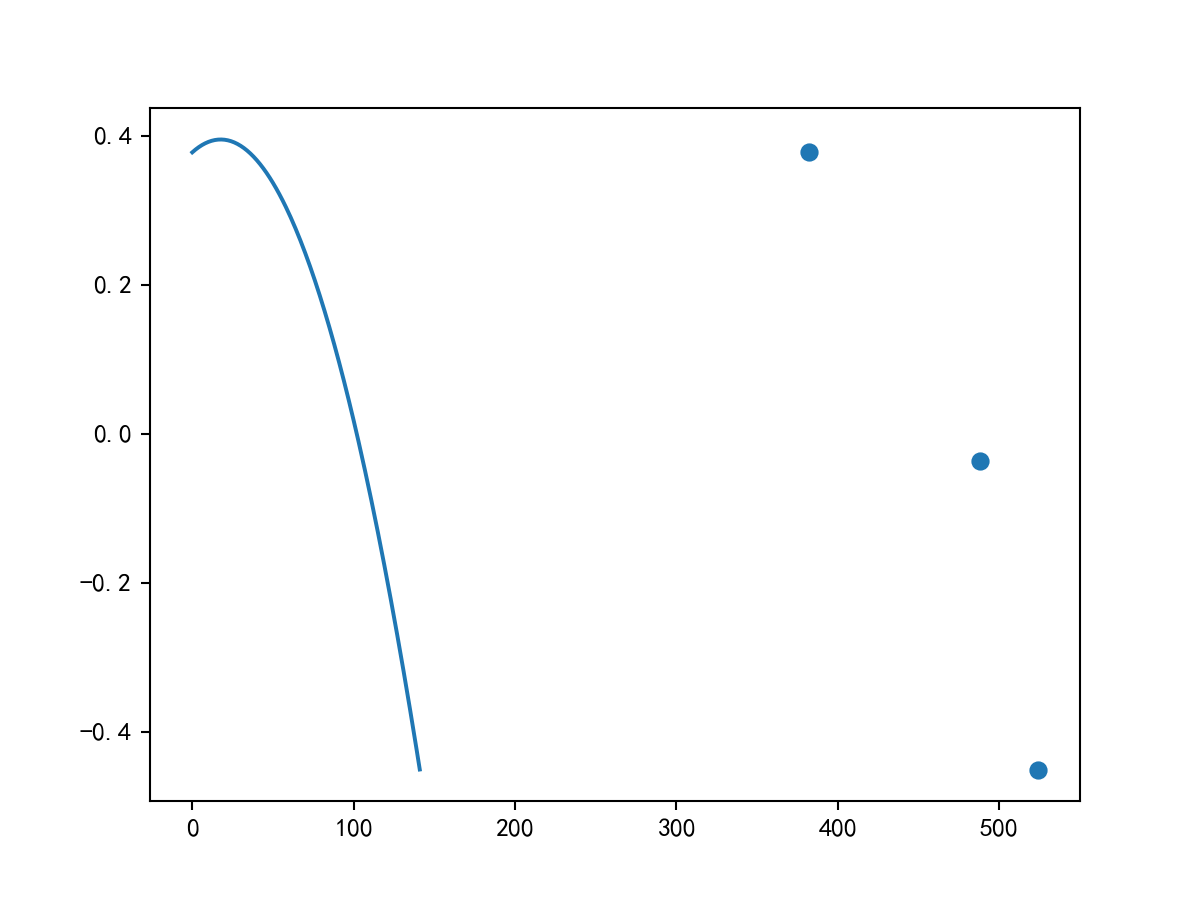

In [9]:
'''
右下支
'''

i = 3
threeX = [ MAXLOC[i-1],MAXLOC[i-1]+abs(MAXLOC[i-1]-MINLOC[i])*3/4,MINLOC[i],]
threeY = [ MAX[i-1],(MAX[i-1]+np.median(MIN))*1/2,np.median(MIN), ]
length = MINLOC[i] - MAXLOC[i-1]

chaZhiResult = chaZhi(threeX,threeY,length)

plt.figure()
plt.scatter(threeX,threeY)
plt.plot(chaZhiResult)
plt.show()

<IPython.core.display.Javascript object>


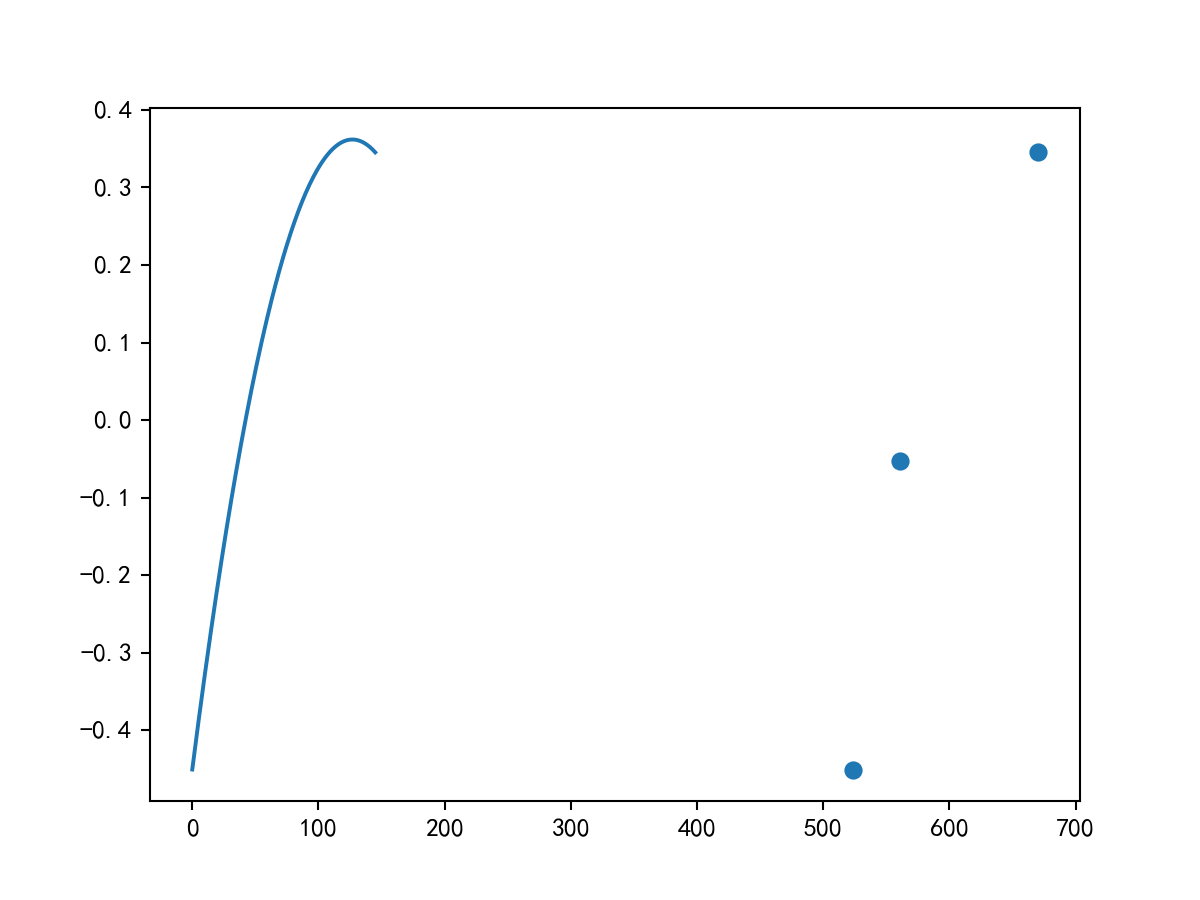

In [10]:
'''

左上支
'''

i = 3
threeX_2 = [ MINLOC[i],MINLOC[i]+abs(MINLOC[i]-MAXLOC[i+1])*1/4,MAXLOC[i+1] ]
threeY_2 = [ np.median(MIN),(MAX[i+1]+np.median(MIN))*1/2 ,MAX[i+1]]
length_2 = MAXLOC[i+1] - MINLOC[i]

chaZhiResult_2 = chaZhi(threeX_2,threeY_2,length_2)

plt.figure()
plt.scatter(threeX_2,threeY_2)
plt.plot(chaZhiResult_2)
plt.show()

In [ ]:
t = np.array(range(2000))

ttt = t[MAXLOC[2]:MINLOC[3]]
ttt_2 = t[MINLOC[3]:MAXLOC[4]]

plt.plot(t,X)
plt.scatter(MINLOC,MIN)
plt.scatter(MAXLOC,MAX)
plt.scatter(MINLOC[i],np.median(MIN))
plt.plot(ttt,chaZhiResult)
plt.plot(ttt_2,chaZhiResult_2)

<IPython.core.display.Javascript object>


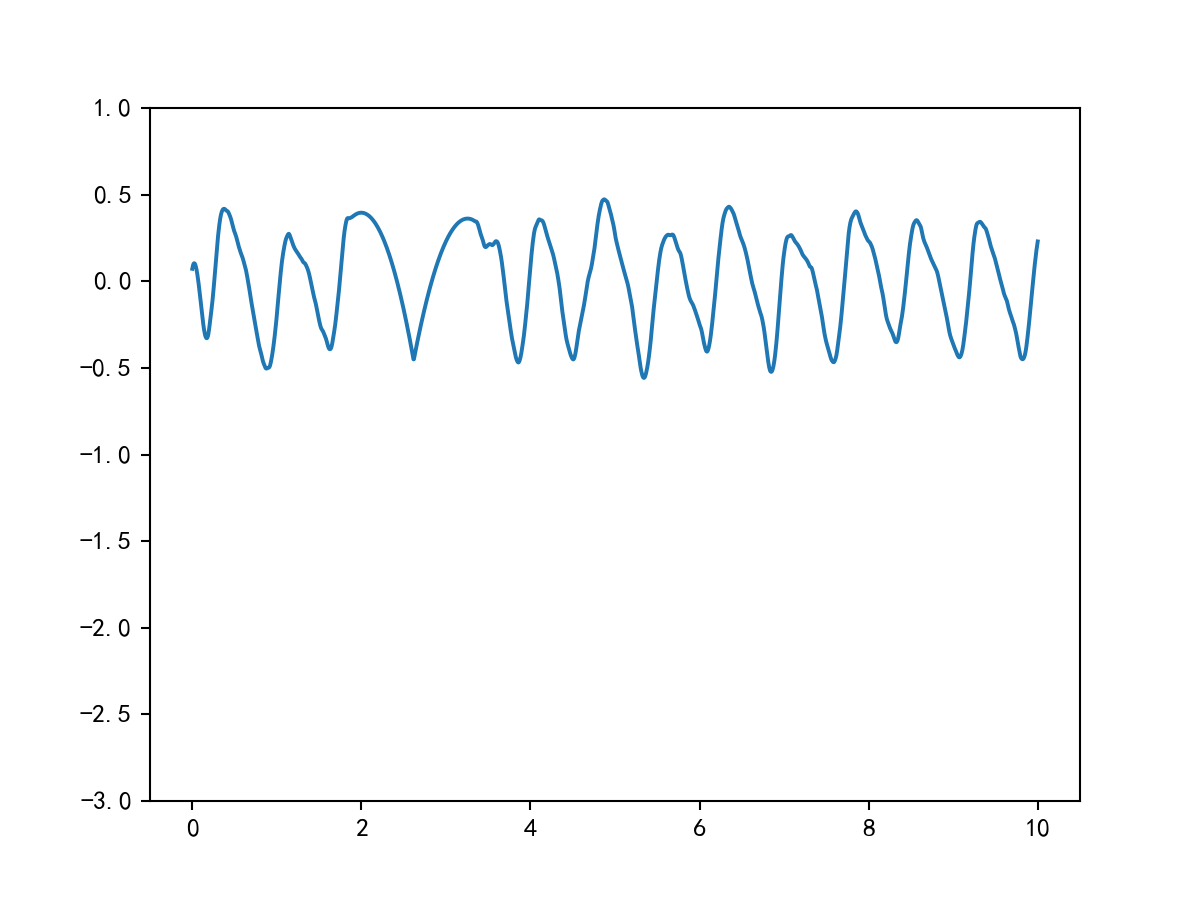

In [11]:
'''
做替换

'''
X = copy.deepcopy(partSignal)
X[MAXLOC[2]:MINLOC[3]] = chaZhiResult
X[MINLOC[3]:MAXLOC[4]] = chaZhiResult_2

plt.figure()
plt.plot(t,X)
plt.ylim([-3,1])
plt.show()

<IPython.core.display.Javascript object>


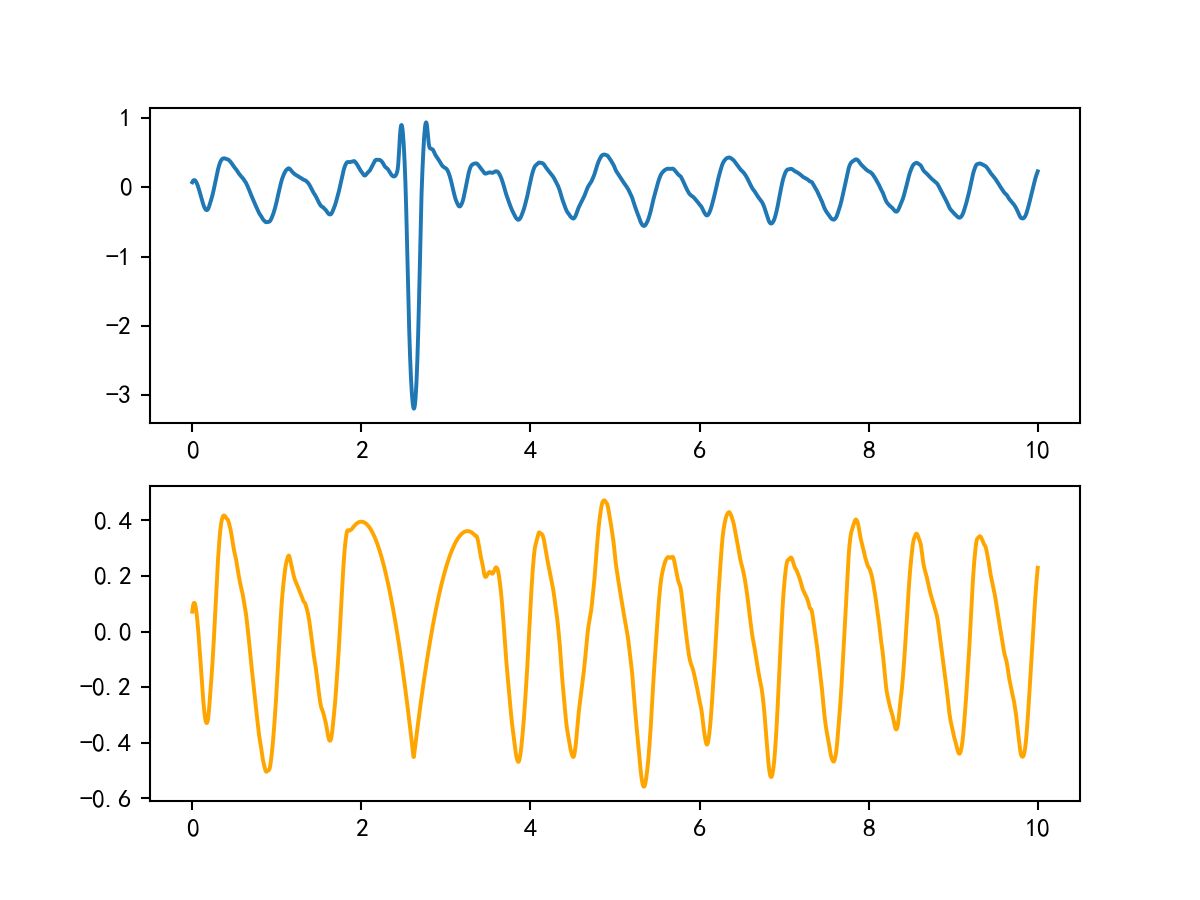

In [14]:
plt.figure()
plt.subplot(2,1,1)
plt.plot(t,partSignal)

plt.subplot(2,1,2)
plt.plot(t,X,c='orange')

plt.show()

In [27]:
plt.figure(figsize=(8,4))

plt.plot(t,partSignal,label='局部异常信号')

MAXLOC, MAX, MINLOC, MIN = getPeakAndTrough(X, alpha=0.9)

plt.plot(t,X,'--',label='局部异常修复后信号')
plt.scatter(t[MAXLOC],MAX,label='修复后信号的峰点',c='r')
plt.scatter(t[MINLOC],MIN,label='修复后信号的谷点')
plt.legend()
plt.title('局部异常信号处理')
plt.xlabel('时间/秒')
plt.ylabel('幅度值')

plt.savefig(r'C:\Users\ASUS\Desktop\毕业论文PPT作图汇总\第三章\图3-12.png',dpi=600, bbox_inches='tight')
plt.show()